# Health Insurance problem




### Contexto: 
A Insurance All é uma empresa que fornece seguro de saúde para seus clientes e o time de produtos está analisando a possibilidade de oferecer aos assegurados, um novo produto: Um seguro de automóveis.

Assim como o seguro de saúde, os clientes desse novo plano de seguro de automóveis precisam pagar um valor anualmente à Insurance All para obter um valor assegurado pela empresa, destinado aos custos de um eventual acidente ou dano ao veículo.

A Insurance All fez uma pesquisa com cerca de 380 mil clientes sobre o interesse em aderir a um novo produto de seguro de automóveis, no ano passado. Todos os clientes demonstraram interesse ou não em adquirir o seguro de automóvel e essas respostas ficaram salvas em um banco de dados junto com outros atributos dos clientes.

O time de produtos selecionou 127 mil novos clientes que não responderam a pesquisa para participar de uma campanha, no qual receberão a oferta do novo produto de seguro de automóveis. A oferta será feita pelo time de vendas através de ligações telefônicas. Contudo, o time de vendas tem uma capacidade de realizar 20 mil ligações dentro do período da campanha. 


### Desafio
Nesse contexto, você foi contratado como um consultor de Ciência de Dados para construir um modelo que prediz se o cliente estaria ou não interessado no seguro de automóvel.
Com a sua solução, o time de vendas espera conseguir priorizar as pessoas com maior interesse no novo produto e assim, otimizar a campanha realizando apenas contatos aos clientes mais propensos a realizar a compra.
Como resultado da sua consultoria, você precisará entregar um relatório contendo algumas análises e respostas às seguintes perguntas: 

1. Principais Insights sobre os atributos mais relevantes de clientes interessados em adquirir um seguro de automóvel.
2. Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel, o time de vendas conseguirá contatar fazendo 20.000 ligações?
3. E se a capacidade do time de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar?
4. Quantas ligações o time de vendas precisa fazer para contatar 80% dos clientes interessados em adquirir um seguro de automóvel?

### Os dados 
- Id: identificador único do cliente.
- Gender: gênero do cliente.
- Age: idade do cliente.
- Driving License: 0, o cliente não tem permissão para dirigir e 1, o cliente tem para dirigir ( CNH – CarteiraNacional de Habilitação )
- Region Code: código da região do cliente.
- Previously Insured: 0, o cliente não tem seguro de automóvel e 1, o cliente já tem seguro de automóvel.
- Vehicle Age: idade do veículo.
- Vehicle Damage: 0, cliente nunca teve seu veículo danificado no passado e 1, cliente já teve seu veículodanificado no passado.
- Anual Premium: quantidade que o cliente pagou à empresa pelo seguro de saúde anual.
- Policy sales channel: código anônimo para o canal de contato com o cliente.
- Vintage: número de dias que o cliente se associou à empresa através
- Response: Pesquisa prévia sobre pessoas que teriam intenção de comprar um seguro de carro

# Set up

### Libraries

In [297]:
import pandas as pd
import inflection
import numpy as np
import seaborn as sns
import dtale
import pickle

from dython                   import nominal
from sklearn                  import ensemble         as en
from sklearn                  import model_selection  as ms
from matplotlib               import pyplot           as plt


from IPython.display          import HTML
from sklearn.preprocessing    import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection  import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.linear_model     import LogisticRegression
from sklearn.tree             import DecisionTreeClassifier
from sklearn.neighbors        import KNeighborsClassifier
from sklearn.ensemble         import RandomForestClassifier, BaggingClassifier
from sklearn.metrics          import accuracy_score, recall_score, precision_score, balanced_accuracy_score, f1_score
from imblearn.over_sampling   import RandomOverSampler
from lightgbm                import LGBMClassifier





### Functions

In [298]:
def change_type(data):   # Changing Type

    data['annual_premium'] = data['annual_premium'].astype(int)
    data['policy_sales_channel'] = data['policy_sales_channel'].astype(int)
    data['annual_premium'] = data['annual_premium'].astype(int)
    data['policy_sales_channel'] = data['policy_sales_channel'].astype(int)
    data['region_code'] = data['region_code'].astype(int)

    change_type = data
    return change_type


def vehicle(data):     # Removendo Year

        if data == '< 1 Year':
            return 0
        elif data == '1-2 Year':
            return 1
        else:
            return 2


def vehicle_change(data):    #Changing Vehicle 

    data['vehicle_damage'] = data.apply( lambda x: 0 if x['vehicle_damage'] == 'No' else 1, axis=1 )
    data['vehicle_age'] = data['vehicle_age'].apply(vehicle)
    
    changes = data
    return changes

def change_all(data):
     data1 = change_type(data)
     changes = vehicle_change(data1)

     return changes

# def submission_preparation(df, features_selected):
    
#     df = limpeza(df)
#     df = feature_engen(df)
#     df = rescalling(df)
#     df = transform(df)
    
#     return df[features_selected]


def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [299]:
jupyter_settings()

### Import Data

In [300]:
df_train_raw = pd.read_csv('train.csv', low_memory=False)
df_test_raw = pd.read_csv('test.csv', low_memory=False)

## ETL

### Data Raw status

In [301]:
df1 = df_train_raw.copy()
df1test = df_test_raw.copy()

In [302]:
df1.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [303]:
df1.head(5)

# Notes: 
# Vehicle_Age: Separar o Year da coluna
# Vehicle_damage: Pode ser 1=yes 0=no (fazer no DF_cat)
# Vintage: coluna de meses / coluna anos 


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [304]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [305]:
df1test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127037 entries, 0 to 127036
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    127037 non-null  int64  
 1   Gender                127037 non-null  object 
 2   Age                   127037 non-null  int64  
 3   Driving_License       127037 non-null  int64  
 4   Region_Code           127037 non-null  float64
 5   Previously_Insured    127037 non-null  int64  
 6   Vehicle_Age           127037 non-null  object 
 7   Vehicle_Damage        127037 non-null  object 
 8   Annual_Premium        127037 non-null  float64
 9   Policy_Sales_Channel  127037 non-null  float64
 10  Vintage               127037 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 10.7+ MB


### Rename Columns

In [306]:
old_columns = [ 'id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']

snakecase = lambda x: inflection.underscore( x )
cols_new = list (map (snakecase, old_columns))

# Rename train
df1.columns = cols_new

old_columns_test = [ 'id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage']

snakecase = lambda x: inflection.underscore( x )
cols_new_test = list (map (snakecase, old_columns_test))

# Rename train
df1test.columns = cols_new_test

### Changing Data

In [307]:
# Vintage: coluna de meses / coluna anos - Vintage: número de dias que o cliente se associou à empresa através ??
# - Anual Premium: quantidade que o cliente pagou à empresa pelo seguro de saúde anual. = formatação de moeda.

df2 = change_all(df1)
df2test = change_all(df1test)

In [308]:
df2.head(1)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28,0,2,1,40454,26,217,1


# Feature Engineering - Later

In [309]:
df3 = df2.copy()
df_cat = df2.copy()

In [310]:
df_cat.head(2)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28,0,2,1,40454,26,217,1
1,2,Male,76,1,3,0,1,0,33536,26,183,0


In [311]:
# Changing var. Categ para o EDA.

# cat_attributes = driving_license, previously_insured, vehicle_damage, gender

df_cat['vehicle_damage'] = df_cat.apply( lambda x: 'no' if x['vehicle_damage'] == 0 else 'yes', axis=1 )
df_cat['driving_license'] = df_cat.apply( lambda x:'no' if x['driving_license'] == 0 else 'yes', axis=1 )
df_cat['previously_insured'] = df_cat.apply( lambda x:'no' if x['previously_insured'] == 0 else 'yes', axis=1 )
    

# EDA - Exploratory Data Analysis

## Descriptive Statistical

### Data Dimensions

Number of Rows 381109
Number of Columns 12


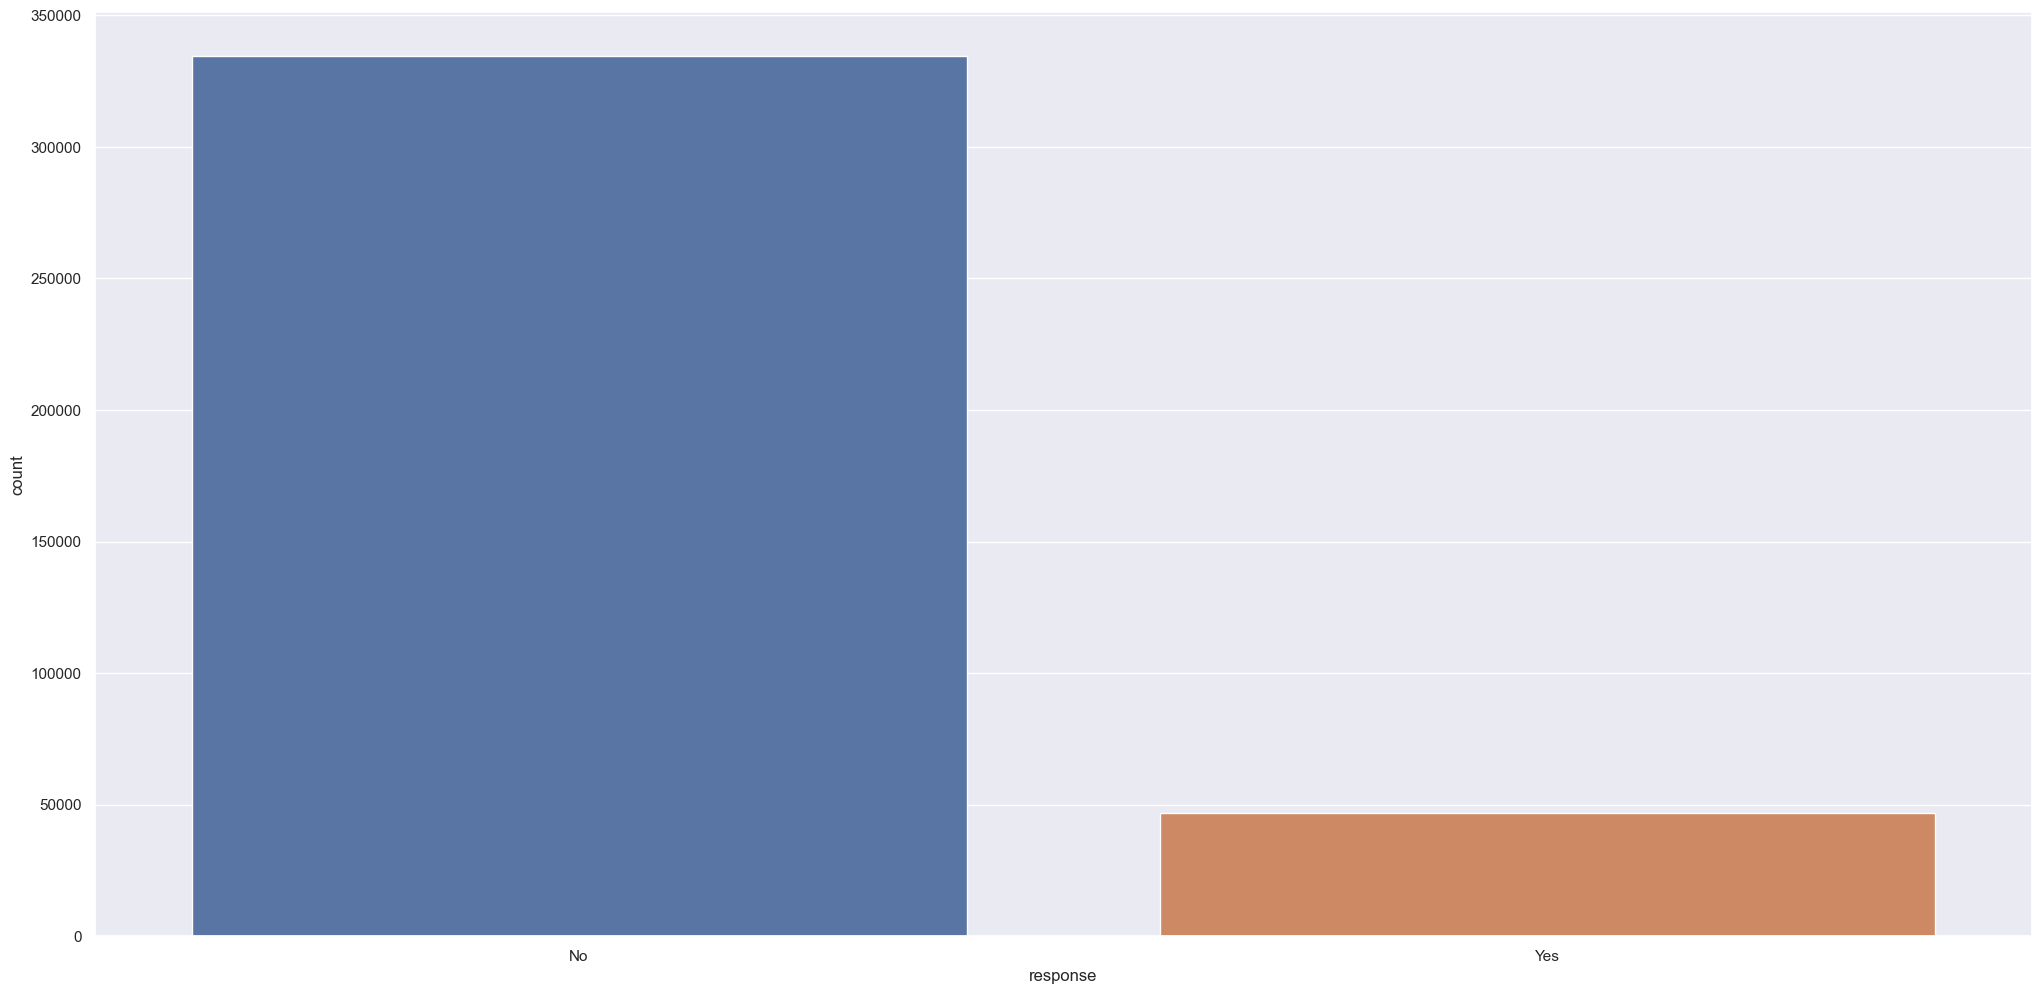

In [312]:
print(f'Number of Rows {df_cat.shape[0]}')
print(f'Number of Columns {df_cat.shape[1]}')

# counts each class for the target var
_ = sns.countplot(x=df_cat['response'])

# sets plot features
plt.xticks(ticks=[0,1], labels=['No','Yes'])

# displays the plot
plt.show()

# BALANCEAR DADOS!!!!!!

### Attributes Analysis

In [313]:
# Split Numerical/Categorical Atributes

num_attributes = df_cat.select_dtypes( include=['int64', 'float64', 'int32'])
cat_attributes = df_cat.select_dtypes( include=['object'])

# Criar: df_eda: 
# num_attributes - int, float
# cat_attributes = driving_license, previously_insured, vehicle_damage, gender

In [314]:
# Cental Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame(num_attributes.apply( np.median )).T


# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( np.min )).T
d3 = pd.DataFrame(num_attributes.apply( np.max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T


# Concatenate
table_m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ]).T.reset_index()
table_m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

table_m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
3,vehicle_age,0.0,2.0,2.0,0.609616,1.0,0.567439,2.528959e-01,-0.792253
4,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
5,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
6,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
7,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


In [315]:
cat_attributes = df_cat.select_dtypes( include=['object']).sample(10)
cat_attributes

,gender,driving_license,previously_insured,vehicle_damage
180652,Female,yes,yes,no
126707,Female,yes,no,yes
199386,Male,yes,no,yes
309793,Female,yes,no,yes
34187,Female,yes,yes,no
314107,Female,yes,no,no
195111,Male,yes,yes,no
301648,Female,yes,yes,no
229634,Male,yes,yes,no
303010,Female,yes,yes,no


## EDA

In [316]:
# # Assigning a reference to a running D-Tale process
# d = dtale.show(df3)

# # Accessing data associated with D-Tale process
# tmp = d.data.copy()
# tmp['d'] = 4

# # Altering data associated with D-Tale process
# # FYI: this will clear any front-end settings you have at the time for this process (filter, sorts, formatting)
# d.data = tmp

# # Shutting down D-Tale process
# #d.kill()

# # using Python's `webbrowser` package it will try and open your server's default browser to this process
# d.open_browser()

# # There is also some helpful metadata about the process
# d._data_id  # the process's data identifier
# d._url  # the url to access the process

# d2 = dtale.get_instance(d._data_id)  # returns a new reference to the instance running at that data_id

# dtale.instances()  # prints a list of all ids & urls of running D-Tale sessions

### Univariate Anaysis

#### Numerial Variable

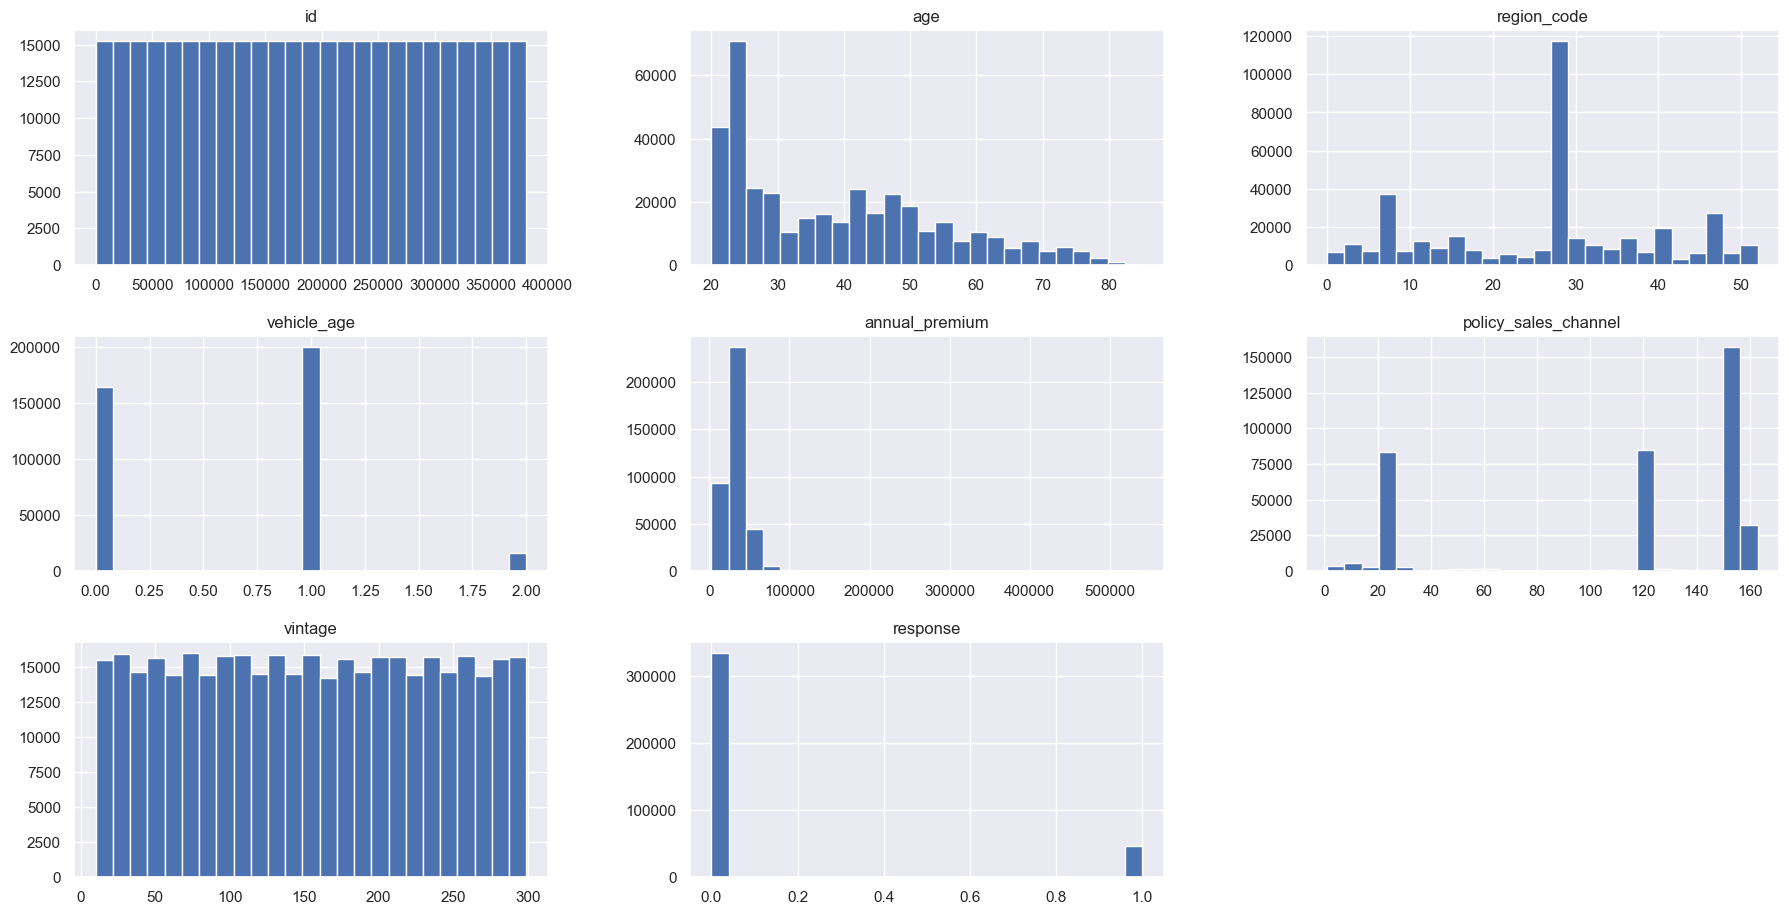

In [317]:
num_attributes.hist( bins=25, figsize=(22,11) );

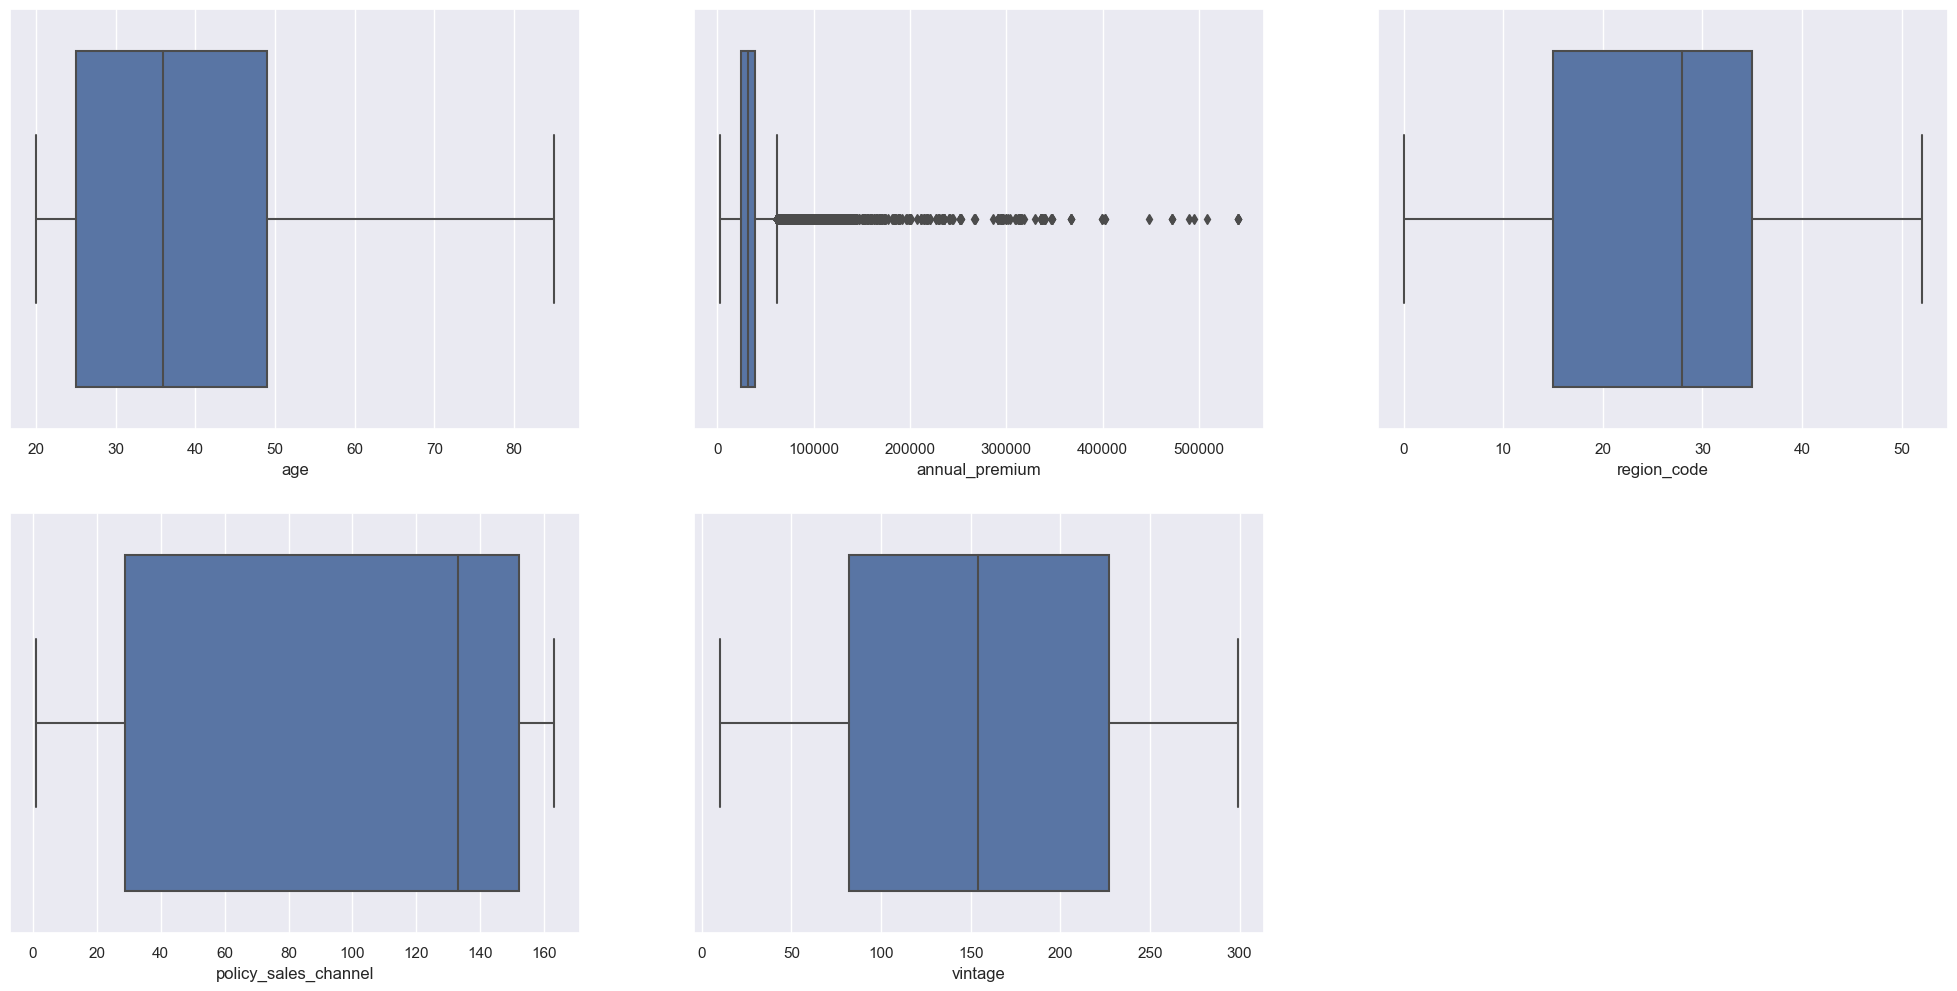

In [318]:
# ver se isso faz sentido

plt.subplot(2, 3, 1)
sns.boxplot(x='age',  data=df_cat);
plt.subplot(2, 3, 2)
sns.boxplot(x='annual_premium',  data=df_cat);
plt.subplot(2, 3, 3)
sns.boxplot(x='region_code',  data=df_cat);
plt.subplot(2, 3, 4)
sns.boxplot(x='policy_sales_channel',  data=df_cat);
plt.subplot(2, 3, 5)
sns.boxplot(x='vintage',  data=df_cat);

#### Categorical Variable

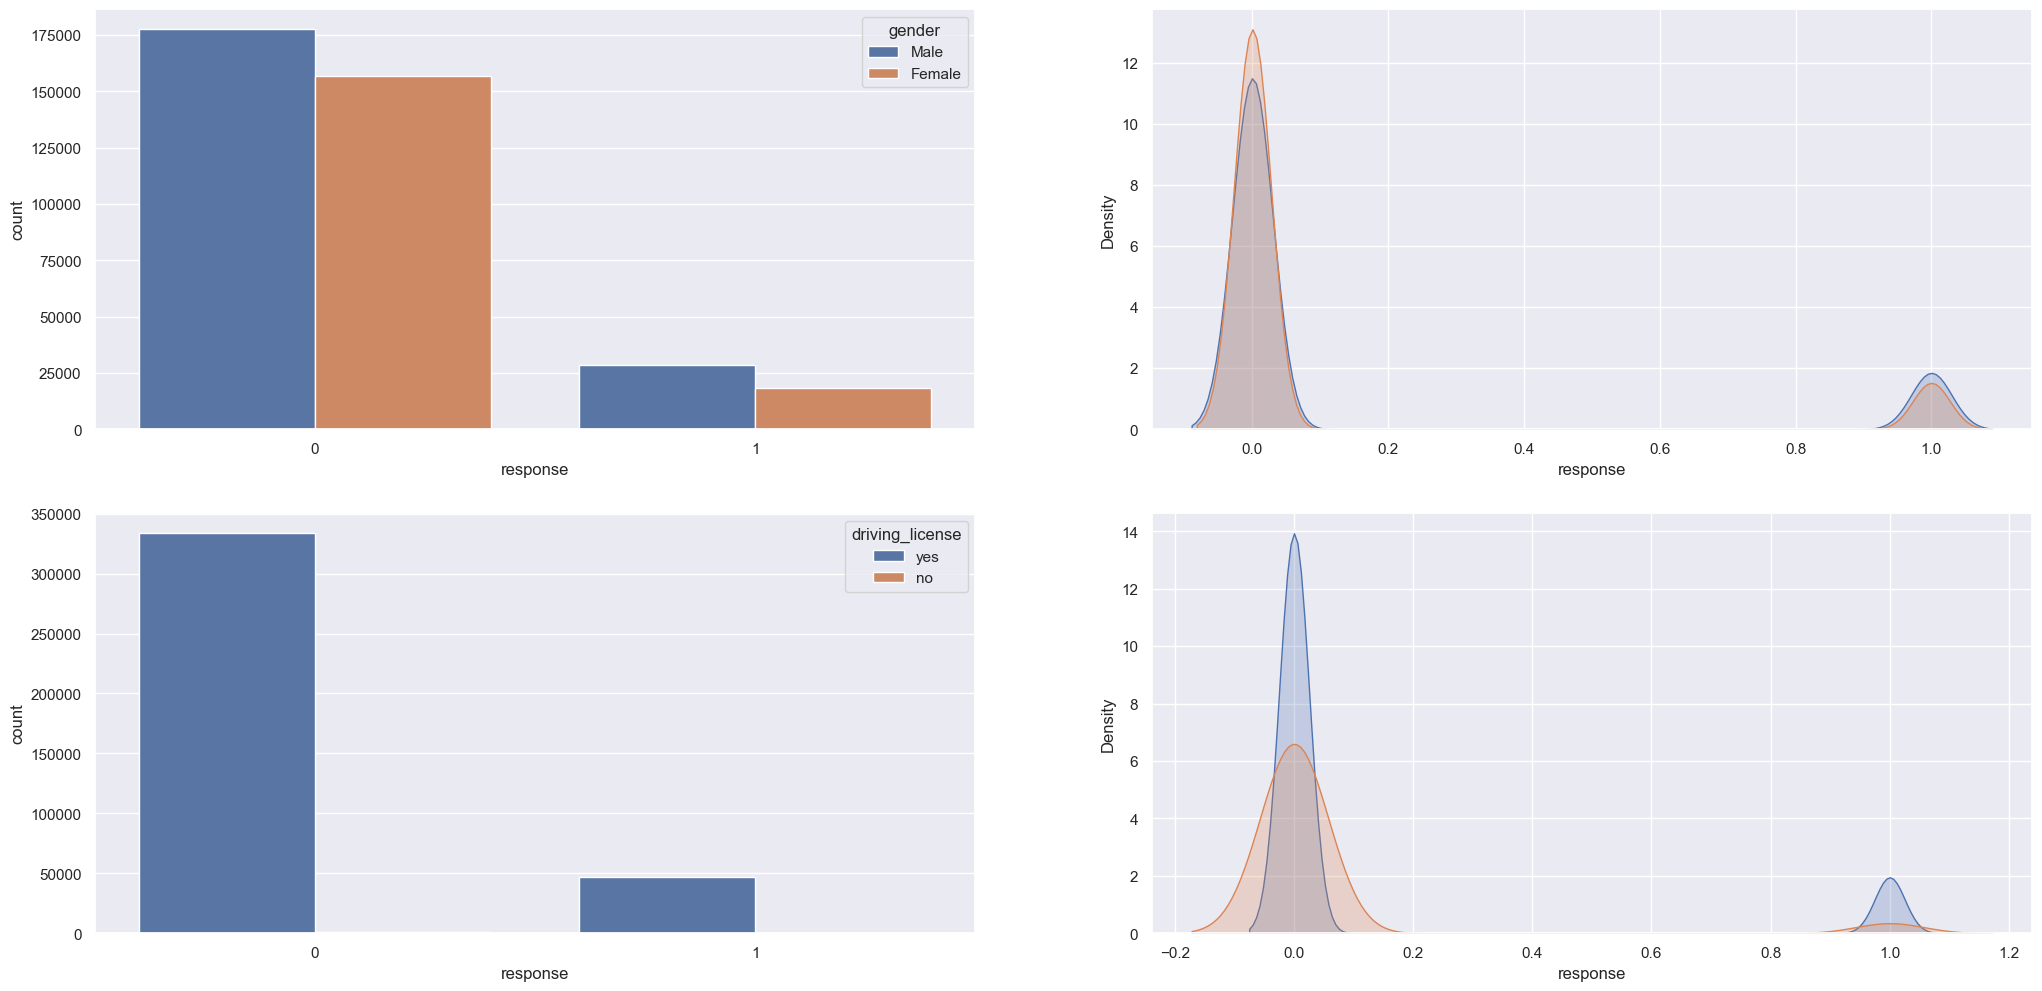

In [319]:
plt.subplot( 2, 2, 1)
sns.countplot(
    x='response',
    hue=('gender'),
    data=df_cat,
);

plt.subplot( 2, 2, 2 )
sns.kdeplot( df_cat[df_cat['gender'] == 'Male']['response'],  fill=True, legend=True  );
sns.kdeplot( df_cat[df_cat['gender'] == 'Female']['response'],  fill=True, legend=True );


plt.subplot( 2, 2, 3)
sns.countplot(
    x='response',
    hue=('driving_license'),
    data=df_cat,
);

plt.subplot( 2, 2, 4 )
sns.kdeplot( df_cat[df_cat['driving_license'] == 'yes']['response'],  fill=True, legend=True  );
sns.kdeplot( df_cat[df_cat['driving_license'] == 'no']['response'],  fill=True, legend=True );




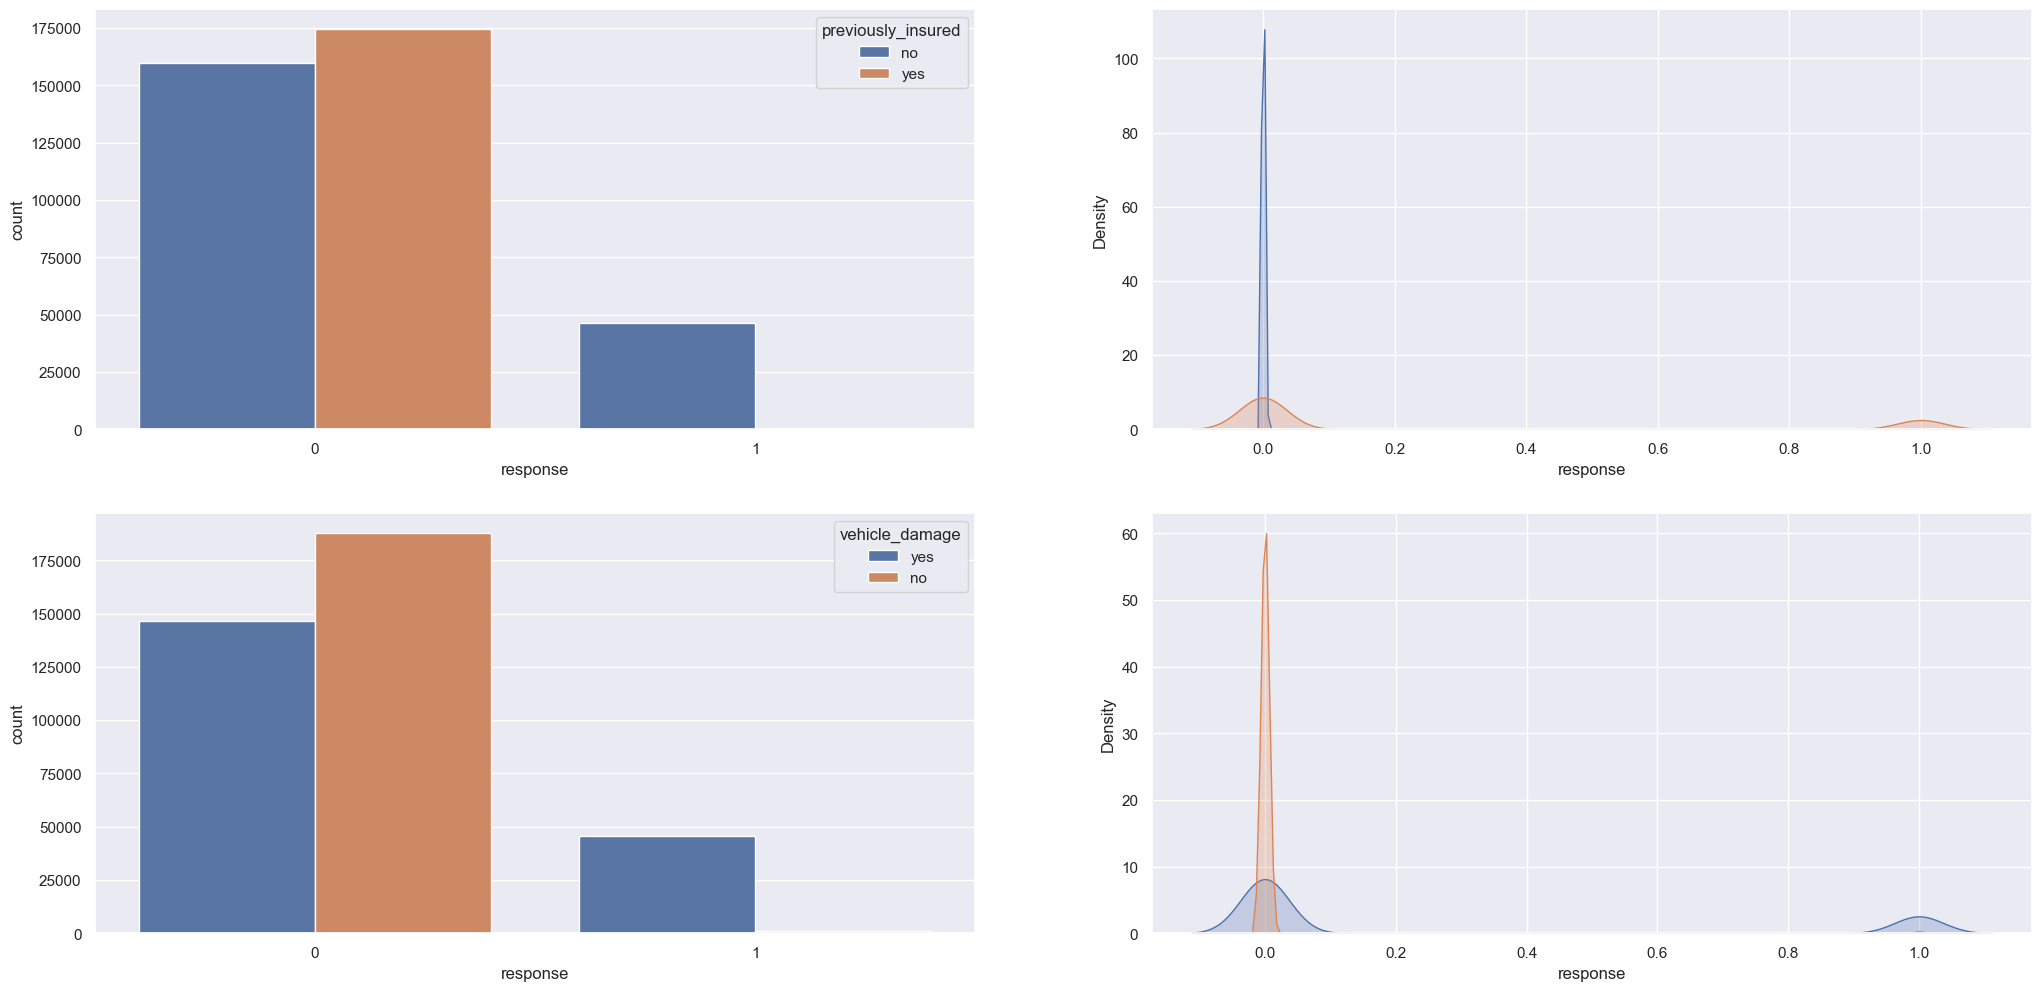

In [320]:
plt.subplot( 2, 2, 1)
sns.countplot(
    x='response',
    hue=('previously_insured'),
    data=df_cat,
);

plt.subplot( 2, 2, 2 )
sns.kdeplot( df_cat[df_cat['previously_insured'] == 'yes']['response'],  fill=True, legend=True  );
sns.kdeplot( df_cat[df_cat['previously_insured'] == 'no']['response'],  fill=True, legend=True );

plt.subplot( 2, 2, 3)
sns.countplot(
    x='response',
    hue=('vehicle_damage'),
    data=df_cat,
);

plt.subplot( 2, 2, 4 )
sns.kdeplot( df_cat[df_cat['vehicle_damage'] == 'yes']['response'],  fill=True, legend=True  );
sns.kdeplot( df_cat[df_cat['vehicle_damage'] == 'no']['response'],  fill=True, legend=True );

### Bivariate Analysis - later

#### Hyphoteses List



- Clientes que já pagaram seguro previamente comprariam novo seguro
- Mulheres compram mais seguros do que homem
- Clientes que vivem em regiões mais perigosas compram mais
- Clientes com mais idade compram mais
- Clientes que não possuem CHN não compram
- Carros mais danificados precisam de seguro
- Carros mais velhos precisam de seguro
- Carros que já possuem seguros não precisam de novo seguro

#### Mental Map

### Multivariate Analysis

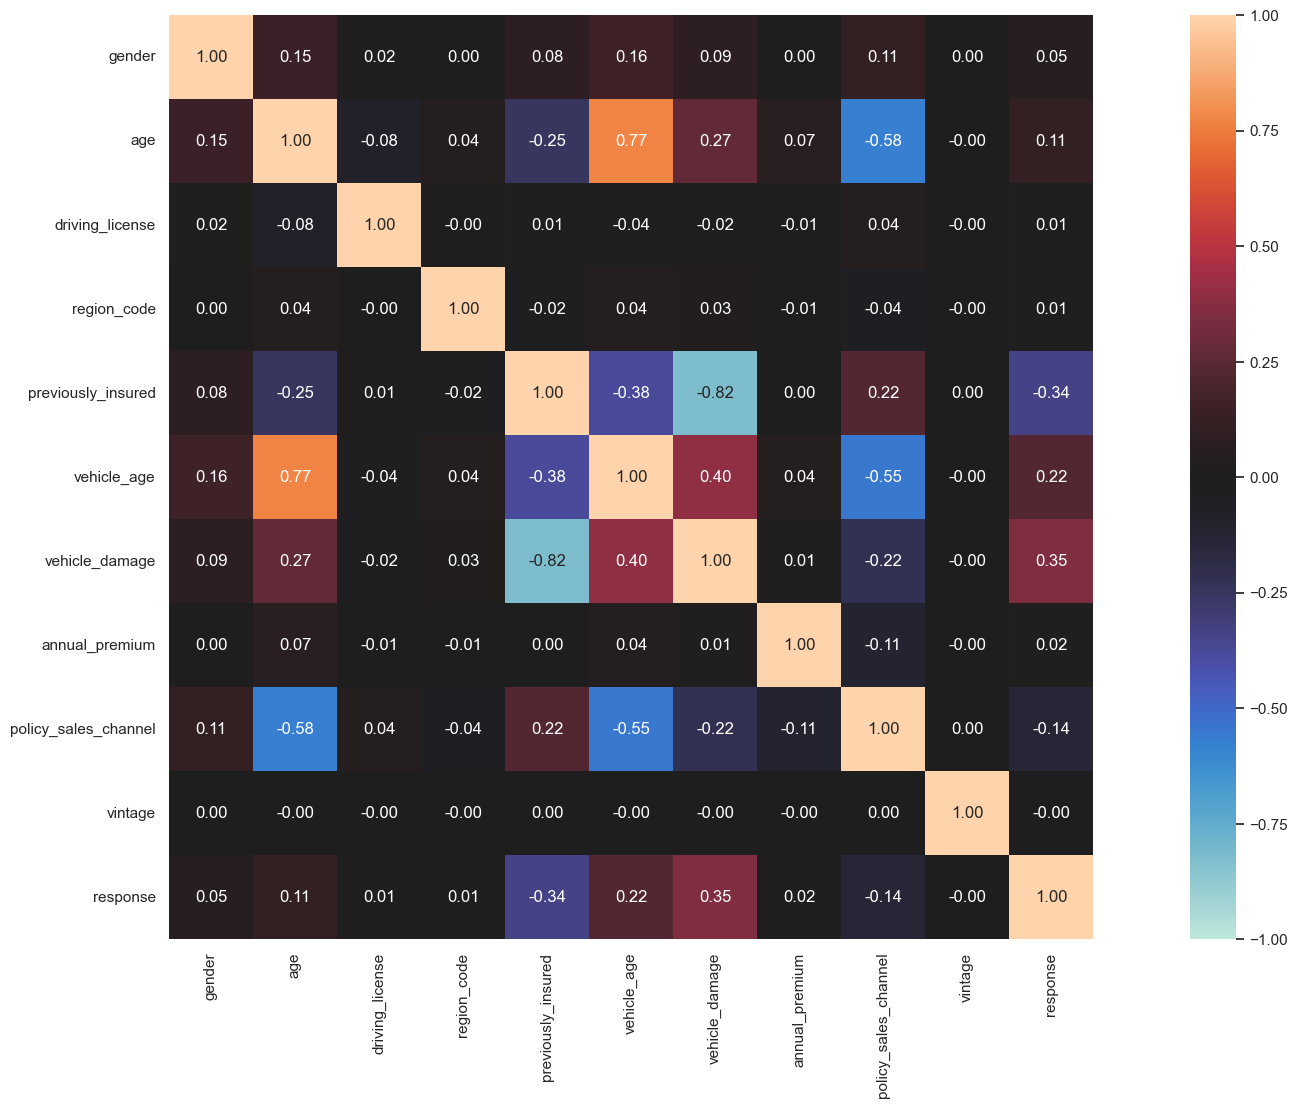

In [321]:
# Numerical
#### Tem que fazer diferente pra variável binária

# Ainda não termineeei!! 
nominal.associations(df2.drop('id',axis = 1));

In [322]:
# Numérica x binária

In [323]:
# Categórica

# Data Preparation

In [324]:
df4 = df2.copy()
df4test = df2test.copy()

### Data Filtering

In [325]:
# Outliers ???


### Data Split

In [326]:
# # Separando as variáveis explicativas da variável resposta.
x_train = df4.drop(['id','response'], axis=1)
y_train = df4['response']

x_test = df4.drop(['id','response'], axis=1)
y_test = df4['response']


In [327]:
# Criar o objeto RandomOverSampler - Ajustando variável 'response' desbalanceada
over_sampler = RandomOverSampler(random_state=42)

# Aplicar o oversampling no conjunto de treinamento
x_train_balanced, y_train_balanced = over_sampler.fit_resample(x_train, y_train)

df_train = pd.concat([x_train_balanced, y_train_balanced], axis=1) # juntar as variaveis preditoras com a variavel alvo
df_teste = pd.concat([x_test, y_test], axis=1) # dados de teste juntos

### Preparation

In [328]:
# Dados de treino - .fit_transform

## Rescaling

# MinMax scaler = sem outlier
# age, region_code, policy_sales_channel, vintage, vehicle_age_year
mms_age = MinMaxScaler()
df_train['age'] = mms_age.fit_transform(df_train[['age']])
pickle.dump(mms_age, open('parameters/mms_age.pkl', 'wb'))

mms_region = MinMaxScaler()
df_train['region_code'] = mms_region.fit_transform(df_train[['region_code']])
pickle.dump(mms_region, open('parameters/mms_region.pkl', 'wb'))

mms_policy = MinMaxScaler()
df_train['policy_sales_channel'] = mms_policy.fit_transform(df_train[['policy_sales_channel']])
pickle.dump(mms_policy, open('parameters/mms_policy.pkl', 'wb'))

mms_vintage = MinMaxScaler()
df_train['vintage'] = mms_vintage.fit_transform(df_train[['vintage']])
pickle.dump(mms_vintage, open('parameters/mms_vintage.pkl', 'wb'))

mms_v_year = MinMaxScaler()
df_train['vehicle_age'] = mms_v_year.fit_transform(df_train[['vehicle_age']])
pickle.dump(mms_v_year, open('parameters/mms_v_year.pkl', 'wb'))


# RobustScaler = com outlier -  annual_premium
rs_premium = RobustScaler()
df_train['annual_premium'] = rs_premium.fit_transform(df_train[['annual_premium']])
pickle.dump(rs_premium, open('parameters/rs_premium.pkl', 'wb'))



## Transformation
# LaberEncoder - Categorical
le_gender = LabelEncoder()
df_train['gender'] = le_gender.fit_transform(df_train[['gender']].values.ravel())
pickle.dump(le_gender, open('parameters/le_gender.pkl', 'wb'))



In [329]:
## Função para aplicar a preparação nos dados de teste 


def prep(X_test):
    # Dados de test - .transform

    ## Rescaling
    mms_age = pickle.load(open('parameters/mms_age.pkl', 'rb'))
    X_test['age'] = mms_age.transform(X_test[['age']])


    mms_region = pickle.load(open('parameters/mms_region.pkl', 'rb'))
    X_test['region_code'] = mms_region.transform(X_test[['region_code']])


    mms_policy = pickle.load(open('parameters/mms_policy.pkl', 'rb'))
    X_test['policy_sales_channel'] = mms_policy.transform(X_test[['policy_sales_channel']])

    mms_vintage = pickle.load(open('parameters/mms_vintage.pkl', 'rb'))
    X_test['vintage'] = mms_vintage.transform(X_test[['vintage']])

    mms_v_year = pickle.load(open('parameters/mms_v_year.pkl', 'rb'))
    X_test['vehicle_age'] = mms_v_year.transform(X_test[['vehicle_age']])


    # RobustScaler 
    rs_premium = pickle.load(open('parameters/rs_premium.pkl', 'rb'))
    X_test['annual_premium'] = rs_premium.transform(X_test[['annual_premium']])



    ## Transformation
    le_gender = pickle.load(open('parameters/le_gender.pkl', 'rb'))
    X_test['gender'] = X_test['gender'].values.ravel()
    X_test['gender'] = le_gender.transform(X_test['gender'])

    return X_test

In [330]:
df_teste_prep = prep(df_teste)

# Feature Selection

In [331]:
#Treino
x_train = df_train.drop(['response'], axis=1)
y_train = df_train['response']


In [332]:
# Crie e treine o modelo LGBMClassifier
lgb_model = LGBMClassifier(n_jobs=-1, random_state=42)
lgb_model.fit(x_train, y_train)

# Obtenha as importâncias das características do modelo
importances = lgb_model.feature_importances_

# Ordene as características por importância decrescente
indices = np.argsort(importances)[::-1]

# Imprima o ranking das características
print('Feature ranking')
df = pd.DataFrame()

for i, j in zip(x_train.columns, importances):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)

print(df.sort_values('importance', ascending=False))


[LightGBM] [Info] Number of positive: 334399, number of negative: 334399
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 751
[LightGBM] [Info] Number of data points in the train set: 668798, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Feature ranking
                feature  importance
0                   age         575
0           region_code         565
0  policy_sales_channel         519
0        annual_premium         442
0               vintage         431
0           vehicle_age         144
0        vehicle_damage         144
0    previously_insured          95
0                gender          62
0       driving_license          23


In [333]:
# Features choose
cols_selected = [ 'age', 'region_code', 'policy_sales_channel', 'annual_premium', 'vintage', 'vehicle_age', 'vehicle_damage', 'previously_insured', 'gender']
#cols_selected =  [ 'vintage', 'annual_premium', 'age', 'region_code','vehicle_damage','policy_sales_channel','previously_insured','vehicle_age_year', ]

# Machine Learning

### Select Cols

In [334]:
#Treino
x_train = df_train[cols_selected]
y_train = df_train['response']

#Teste
x_teste = df_teste_prep[cols_selected]
y_teste = df_teste_prep['response']

### Machine Learning

In [339]:
# verificando a performance da Regressão Logística
def MachineLearning(dataset):

    nome_das_medidas = ['acurácia', 'sensibilidade', 'vpp', 'eficiência', 'f1-score']

    lista_de_modelos = [LogisticRegression(),
                        DecisionTreeClassifier(max_depth = 3),
                        DecisionTreeClassifier(max_depth = 5),
                        DecisionTreeClassifier(max_depth = 7),
                        KNeighborsClassifier(n_neighbors = 5),
                        KNeighborsClassifier(n_neighbors = 15),
                        KNeighborsClassifier(n_neighbors = 25),
                        BaggingClassifier(),
                        RandomForestClassifier(n_estimators=300, max_depth = 3, max_features = 3),
                        RandomForestClassifier(n_estimators=300, max_depth = 3, max_features = 4),
                        RandomForestClassifier(n_estimators=300, max_depth = 6, max_features = 3),
                        RandomForestClassifier(n_estimators=300, max_depth = 6, max_features = 4)]

    nome_dos_modelos = ['Regressão Logística',
                        'Árvore (prof = 3)',
                        'Árvore (prof = 5)',
                        'Árvore (prof = 7)',
                        '5-NN',
                        '15-NN',
                        '25-NN',
                        'Bagging',
                        'Random Forest (prof = 3, mf = 3)',
                        'Random Forest (prof = 3, mf = 4)',
                        'Random Forest (prof = 6, mf = 3)',
                        'Random Forest (prof = 6, mf = 4)']

    resultados0 = {}

    for i in range(len(lista_de_modelos)):
        print('Rodando modelo: ' + nome_dos_modelos[i])

        model = lista_de_modelos[i]

        model.fit(x_train, y_train)

        y_pred = model.predict(x_teste)

        acc = accuracy_score(y_teste, y_pred)
        sen = recall_score(y_teste, y_pred)
        vpp = precision_score(y_teste, y_pred)
        bac = balanced_accuracy_score(y_teste, y_pred)
        f1s = f1_score(y_teste, y_pred)

        resultados0[nome_dos_modelos[i]] = [acc, sen, vpp, f1s, bac]
    
    resultados = pd.DataFrame(resultados0, index = nome_das_medidas).T

    return resultados

In [340]:
MachineLearning(df_train)


Rodando modelo: Regressão Logística
Rodando modelo: Árvore (prof = 3)
Rodando modelo: Árvore (prof = 5)
Rodando modelo: Árvore (prof = 7)
Rodando modelo: 5-NN
Rodando modelo: 15-NN
Rodando modelo: 25-NN
Rodando modelo: Bagging
Rodando modelo: Random Forest (prof = 3, mf = 3)
Rodando modelo: Random Forest (prof = 3, mf = 4)
Rodando modelo: Random Forest (prof = 6, mf = 3)
Rodando modelo: Random Forest (prof = 6, mf = 4)


,acurácia,sensibilidade,vpp,eficiência,f1-score
Regressão Logística,0.638177,0.976472,0.250052,0.398148,0.783697
Árvore (prof = 3),0.709884,0.886919,0.282376,0.428369,0.786037
Árvore (prof = 5),0.699787,0.913295,0.278780,0.427168,0.791629
Árvore (prof = 7),0.681506,0.947848,0.271255,0.421800,0.796075
5-NN,0.849012,0.994241,0.447775,0.617464,0.911483
15-NN,0.747621,0.936844,0.319430,0.476419,0.829017
25-NN,0.727920,0.928902,0.301816,0.455599,0.814374
Bagging,0.998470,0.999700,0.987961,0.993796,0.998999
"Random Forest (prof = 3, mf = 3)",0.684508,0.940677,0.272228,0.422257,0.794701
"Random Forest (prof = 3, mf = 4)",0.676384,0.949133,0.268218,0.418243,0.793709


### Best models compare

In [341]:
# modelo Bagging
bg = BaggingClassifier()

x_train = df_train.drop('response', axis=1)
y_train = df_train['response']

bg.fit(x_train, y_train)
# Fazendo a validação cruzada para obter as previsões do modelo
y_pred_cv = cross_val_predict(bg, x_teste, y_teste, cv=5)

# Calculando as métricas de avaliação com base nas previsões da validação cruzada
accuracy = accuracy_score(y_teste, y_pred_cv)
recall = recall_score(y_teste, y_pred_cv)
precision = precision_score(y_teste, y_pred_cv)
balanced_accuracy = balanced_accuracy_score(y_teste, y_pred_cv)
f1 = f1_score(y_teste, y_pred_cv)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("Balanced Accuracy:", balanced_accuracy)
print("F1 Score:", f1)

Accuracy: 0.861674743970885
Recall: 0.14311710554485121
Precision: 0.3449966455075605
Balanced Accuracy: 0.5525812232947657
F1 Score: 0.20230907742823853


# Fine Tuning

### Final Result

### Cross-Validation

In [ ]:
# # Validação cruzada Leave One Out
# kf = StratifiedKFold(n_splits = 10)

# # Verificando a performance da Regressão Logística

# lista_de_medidas = ['precision']

# modelo = LogisticRegression()
# accs_vc = cross_validate(modelo, x_train_balanced, y_train_balanced, cv = kf, scoring = lista_de_medidas)

# print(accs_vc['test_precision'].mean())

# Business Performance